# Comparisson of proposed solution vs zero-shot BART

In [54]:
import pandas as pd
import torch
from transformers import BartForSequenceClassification, BartTokenizer, __version__ as tv
from sklearn.metrics import f1_score
from utils.plot import plot_conf_matrix
from scripts.TwitterDataset import *
import torchvision

## BART (baseline)

### create instance of pre-trained model

In [55]:
DEVICE = "cpu"


class BartZeroShot:
    def __init__(self):
        self.nli_model = BartForSequenceClassification.from_pretrained(
            "facebook/bart-large-mnli"
        )
        self.nli_model = self.nli_model.to(DEVICE)
        self.tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-mnli")

    def predict(self, sentence, label):
        x = self.tokenizer.encode(
            sentence,
            f"this text is {label}",  # f'This text is about {label}.',
            return_tensors="pt",
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            truncation_strategy="only_first",
        )

        logits = self.nli_model(x.to(DEVICE))[0]

        entail_contradiction_logits = logits[:, [0, 2]]
        probs = entail_contradiction_logits.softmax(1)
        prob_label_is_true = probs[:, 1].item()
        return prob_label_is_true

bz = BartZeroShot()

Measure classification accuracy directly using the columns __is_positive__ and __bart_is_positive__:

accuracy: 70.3800%
f1 score: 0.6563


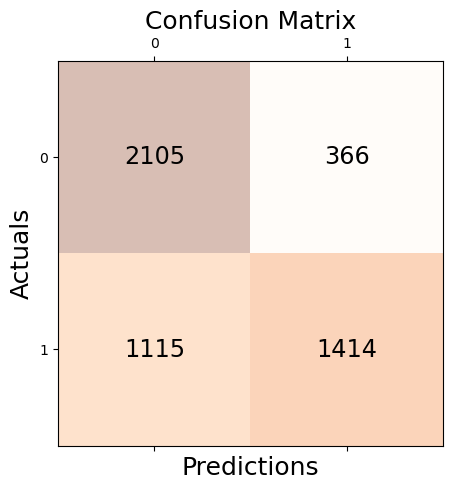

In [56]:
df_twitter_small = pd.read_csv("data/raw/dataset_small_w_bart_preds.csv", delimiter=",")
df_twitter_small = df_twitter_small[-5000:]

y_true = df_twitter_small.is_positive
y_predicted = df_twitter_small.bart_is_positive.round() # make output binary

acc1 = y_predicted.eq(y_true).sum() / float(y_true.shape[0])
print(f"accuracy: {100 * acc1.item():.4f}%")

f1 = f1_score(
    y_true,
    y_predicted,
)
print(f"f1 score: {f1:.4f}")
plot_conf_matrix(y_true, y_predicted)

The accuracy was also double checked below using the model itself to predict the labels.

Now commented out due to the long computation time withou GPU

In [57]:
""" composed = torchvision.transforms.Compose([ToToken(), ToTensor()])
dataset = TwitterDataset_small_test(transform=composed)

x = dataset.x
y = dataset.y

correct = 0

with torch.no_grad():
    for message, label in zip(x, y):
        prediction = bz.predict(message, "positive")
        if round(prediction) == label:
            correct += 1

acc2 = correct / float(y.shape[0])
print(f"accuracy: {acc2:.4f}") """

' composed = torchvision.transforms.Compose([ToToken(), ToTensor()])\ndataset = TwitterDataset_small_test(transform=composed)\n\nx = dataset.x\ny = dataset.y\n\ncorrect = 0\n\nwith torch.no_grad():\n    for message, label in zip(x, y):\n        prediction = bz.predict(message, "positive")\n        if round(prediction) == label:\n            correct += 1\n\nacc2 = correct / float(y.shape[0])\nprint(f"accuracy: {acc2:.4f}") '

## FeedForward NN

In [63]:
from scripts.BinaryFFNN import BinaryFFNN

input_size = 512
hidden_size = 100
PATH = 'models/FFNN_dropout100.pth'

model = BinaryFFNN(input_size, hidden_size)  # create an instance of the model
model.load_state_dict(torch.load(PATH))  # load the saved state dictionary

<All keys matched successfully>

In [64]:
composed = torchvision.transforms.Compose([ToToken(), ToTensor()])
test_dataset = TwitterDataset_small_test(transform=composed)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=test_dataset.n_samples
)

with torch.no_grad():
    n_samples = 0
    n_correct = 0
    for tokens, labels in test_loader: # single batch
        outputs = model(tokens)
    
        predicted_labels = outputs.round()

        n_samples += labels.size(0)
        n_correct += (predicted_labels == labels).sum().item()


        acc = 100.0 * n_correct / n_samples
        print(f"Accuracy of the network on the test set: {acc} %")

Accuracy of the network on the test set: 76.22 %
